## Example Dataset

In [1]:
import lale.datasets
(train_X, train_y), (test_X, test_y) = lale.datasets.covtype_df(test_size=0.9)

In [2]:
print(f'shape train_X {train_X.shape}, test_X {test_X.shape}')

shape train_X (58101, 54), test_X (522911, 54)


In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.concat([pd.DataFrame({'y': train_y}, index=train_X.index),
           train_X], axis=1).tail(10)

,y,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
58091,5,2771.0,57.0,25.0,323.0,108.0,342.0,228.0,178.0,69.0,2188.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58092,2,2633.0,108.0,14.0,182.0,21.0,764.0,243.0,223.0,106.0,1146.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58093,1,3099.0,240.0,16.0,228.0,57.0,2989.0,187.0,252.0,200.0,1485.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58094,2,2991.0,16.0,12.0,210.0,35.0,4049.0,210.0,215.0,141.0,1040.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58095,2,2712.0,44.0,14.0,511.0,32.0,1282.0,222.0,208.0,117.0,2759.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58096,1,3182.0,70.0,13.0,362.0,40.0,2992.0,234.0,214.0,109.0,4336.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58097,1,3172.0,156.0,29.0,716.0,291.0,1154.0,237.0,228.0,98.0,2837.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58098,1,3153.0,287.0,17.0,335.0,41.0,1298.0,171.0,237.0,205.0,2045.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58099,2,3065.0,348.0,21.0,124.0,19.0,4725.0,177.0,202.0,159.0,624.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58100,1,3021.0,26.0,16.0,60.0,7.0,3961.0,211.0,204.0,125.0,2496.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
train_X.json_schema

{'description': 'Features of forest covertypes dataset (classification).',
 'documentation_url': 'https://scikit-learn.org/0.20/datasets/index.html#forest-covertypes',
 'type': 'array',
 'items': {'type': 'array',
  'minItems': 54,
  'maxItems': 54,
  'items': [{'description': 'Elevation', 'type': 'integer'},
   {'description': 'Aspect', 'type': 'integer'},
   {'description': 'Slope', 'type': 'integer'},
   {'description': 'Horizontal_Distance_To_Hydrology', 'type': 'integer'},
   {'description': 'Vertical_Distance_To_Hydrology', 'type': 'integer'},
   {'description': 'Horizontal_Distance_To_Roadways', 'type': 'integer'},
   {'description': 'Hillshade_9am', 'type': 'integer'},
   {'description': 'Hillshade_Noon', 'type': 'integer'},
   {'description': 'Hillshade_3pm', 'type': 'integer'},
   {'description': 'Horizontal_Distance_To_Fire_Points', 'type': 'integer'},
   {'description': 'Wilderness_Area1', 'enum': [0, 1]},
   {'description': 'Wilderness_Area2', 'enum': [0, 1]},
   {'descrip

## Manual Pipeline

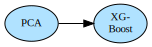

In [5]:
from sklearn.decomposition import PCA
from xgboost import XGBClassifier as XGBoost
lale.wrap_imported_operators()

manual_trainable = PCA(n_components=6) >> XGBoost(n_estimators=3)
manual_trainable.visualize()

In [6]:
%%time
manual_trained = manual_trainable.fit(train_X, train_y)

CPU times: user 2.39 s, sys: 1.17 s, total: 3.56 s
Wall time: 1.98 s


In [7]:
import sklearn.metrics
manual_y = manual_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, manual_y):.1%}')

accuracy 65.7%


## Hyperparameter Tuning

In [8]:
from lale.lib.lale import Hyperopt
import lale.schemas as schemas

CustomPCA = PCA.customize_schema(n_components=schemas.Int(min=2, max=54))
CustomXGBoost = XGBoost.customize_schema(n_estimators=schemas.Int(min=1, max=10))

hpo_planned = CustomPCA >> CustomXGBoost
hpo_trainable = Hyperopt(estimator=hpo_planned, max_evals=10, cv=3)

In [9]:
%%time
hpo_trained = hpo_trainable.fit(train_X, train_y)

100%|███████| 10/10 [01:42<00:00, 10.11s/trial, best loss: -0.7965957865133036]
CPU times: user 2min 9s, sys: 18 s, total: 2min 27s
Wall time: 1min 56s


In [10]:
hpo_y = hpo_trained.predict(test_X)
print(f'accuracy {sklearn.metrics.accuracy_score(test_y, hpo_y):.1%}')

accuracy 80.5%


## Inspecting Automation Results

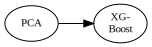

In [11]:
hpo_trained.get_pipeline().visualize()

In [12]:
hpo_trained.get_pipeline().pretty_print(ipython_display=True)

```python
from lale.lib.sklearn import PCA
from lale.lib.xgboost.xgb_classifier import XGBoost
import lale
lale.wrap_imported_operators()

pca = PCA(n_components=39, svd_solver='full')
xg_boost = XGBoost(colsample_bylevel=0.6016063807304212, colsample_bytree=0.7763972782064467, learning_rate=0.16389357351003786, max_depth=10, min_child_weight=5, n_estimators=5, reg_alpha=0.10485915855270356, reg_lambda=0.9268502695024392, subsample=0.4503841871781402)
pipeline = pca >> xg_boost
```

In [13]:
hpo_trained.summary()

,tid,loss,time,log_loss,status
name,,,,,
p0,0,-0.676563,1.708628,1.234038,ok
p1,1,-0.641228,1.655341,1.109479,ok
p2,2,-0.679868,2.918797,1.075010,ok
p3,3,-0.796596,5.960960,1.035531,ok
p4,4,-0.728645,4.553823,0.653845,ok
p5,5,-0.484122,2.592518,1.230732,ok
p6,6,-0.484122,1.748079,1.329945,ok
p7,7,-0.676546,3.502366,0.833122,ok
p8,8,-0.640195,2.609035,0.910650,ok


In [14]:
worst_name = hpo_trained.summary().loss.argmax()
print(worst_name)

p5


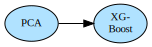

```python
pca = PCA(n_components=48, svd_solver='full', whiten=True)
xg_boost = XGBoost(booster='gblinear', colsample_bylevel=0.41777546097517426, colsample_bytree=0.6852556915729863, learning_rate=0.4299362917360751, max_depth=15, min_child_weight=18, n_estimators=7, reg_alpha=0.5266202371276923, reg_lambda=0.494226267796831, subsample=0.8015579071911012)
pipeline = pca >> xg_boost
```

In [15]:
hpo_trained.get_pipeline(worst_name).visualize()
hpo_trained.get_pipeline(worst_name).pretty_print(ipython_display=True, show_imports=False)

## Transparent Pipeline

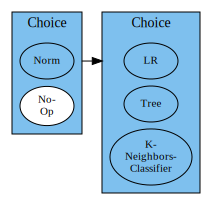

In [16]:
from sklearn.preprocessing import Normalizer as Norm
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as Tree
from sklearn.neighbors import KNeighborsClassifier
from lale.lib.lale import NoOp
lale.wrap_imported_operators()

KNN = KNeighborsClassifier.customize_schema(n_neighbors=schemas.Int(min=1, max=10))
auto_planned = (Norm | NoOp) >> (LR | Tree | KNN)
auto_planned.visualize()

In [17]:
%%time
from lale.lib.lale import Hyperopt
auto_trained = auto_planned.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, max_evals=5)

100%|█████████| 5/5 [02:07<00:00, 17.31s/trial, best loss: -0.8469388647297208]
CPU times: user 2min 21s, sys: 18.8 s, total: 2min 39s
Wall time: 2min 9s


```python
k_neighbors_classifier = KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=9)
pipeline = NoOp() >> k_neighbors_classifier
```

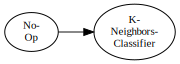

In [18]:
auto_trained.pretty_print(ipython_display=True, show_imports=False)
auto_trained.visualize()

In [19]:
%%time
auto_y = auto_trained.predict(test_X.head(50000))
print(f'accuracy {sklearn.metrics.accuracy_score(test_y.head(50000), auto_y):.1%}')

accuracy 87.4%
CPU times: user 49 s, sys: 141 ms, total: 49.1 s
Wall time: 52 s
